In [1]:
import osmnx as ox, geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from libpysal import weights
import momepy
import pickle

# Data cleaning

In [2]:
# Create a graph from an address with a specific distance around it
G4 = ox.graph_from_address(
    address="Churchillplein 10, 2517 KK, Den Haag",
    dist=2000, # 2000 meters from the address
    dist_type="network", # Following streets
    network_type="drive", # Only drivable roads
    
)

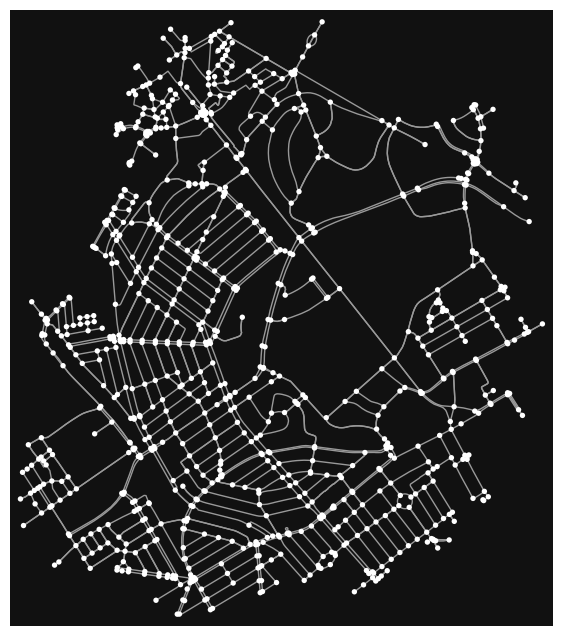

In [3]:
# Project the graph to the UTM zone appropriate for its geographic location
G4_projected = ox.project_graph(G4)
# Plot the projected graph
fig, ax = ox.plot_graph(G4_projected)

In [4]:
type(G4)

networkx.classes.multidigraph.MultiDiGraph

In [5]:
# Convert the graph to GeoDataFrames
nodes, edges = momepy.nx_to_gdf(G4_projected, points=True, lines=True)

C:\Users\mnmar\AppData\Local\Temp\ipykernel_28876\917018790.py:2: UserWarning: Approach is not set. Defaulting to 'primal'.
  nodes, edges = momepy.nx_to_gdf(G4_projected, points=True, lines=True)


In [6]:
display(nodes.head())

,y,x,street_count,lon,lat,nodeID,highway,geometry
0,5.773575e+06,587695.118664,3,4.280459,52.105760,0,NaN,POINT (587695.119 5773574.589)
1,5.773627e+06,587639.939662,3,4.279667,52.106239,1,NaN,POINT (587639.940 5773626.917)
2,5.773613e+06,587721.009144,3,4.280847,52.106100,2,NaN,POINT (587721.009 5773612.905)
3,5.773557e+06,587682.872255,3,4.280276,52.105600,3,NaN,POINT (587682.872 5773556.583)
4,5.773644e+06,587667.226416,4,4.280070,52.106391,4,NaN,POINT (587667.226 5773644.330)


In [7]:
display(edges.head())

,osmid,name,highway,maxspeed,oneway,reversed,length,width,geometry,lanes,ref,bridge,junction,access,tunnel,node_start,node_end
0,4478977,Marcelisstraat,residential,30,False,False,75.920,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,0,1
1,208063030,Stuurmanstraat,residential,30,False,False,46.188,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,0,2
2,208063030,Stuurmanstraat,residential,30,False,True,21.749,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,0,3
3,4478977,Marcelisstraat,residential,30,False,True,75.920,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,1,0
4,7495779,Marcelisstraat,residential,30,True,False,32.299,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,1,4


# Check for column data types, NaN values and duplicates

In [8]:
# Check data types of nodes DataFrame
print(nodes.dtypes)

# Check data types of edges DataFrame
print(edges.dtypes)

y                float64
x                float64
street_count       int64
lon              float64
lat              float64
nodeID             int64
highway           object
geometry        geometry
dtype: object
osmid           object
name            object
highway         object
maxspeed        object
oneway            bool
reversed        object
length         float64
width           object
geometry      geometry
lanes           object
ref             object
bridge          object
junction        object
access          object
tunnel          object
node_start       int64
node_end         int64
dtype: object


Maxspeed, width and lanes should be checked if they are consistently numeric.

In [9]:
edges['maxspeed']

0             30
1             30
2             30
3             30
4             30
          ...   
1822          30
1823          30
1824          50
1825    [50, 30]
1826          50
Name: maxspeed, Length: 1827, dtype: object

We can see that there are lists sometimes, so they should be solved

In [10]:
def handle_maxspeed(value):
    if isinstance(value, list):
        return value[0]  # to take the smallest value
    return value

edges['maxspeed'] = edges['maxspeed'].apply(handle_maxspeed).astype(float)

In [11]:
edges['maxspeed'].unique()

array([30., 50., nan, 15.])

In [12]:
edges['width'].unique

<bound method Series.unique of 0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
1822    NaN
1823    NaN
1824    NaN
1825    NaN
1826    NaN
Name: width, Length: 1827, dtype: object>

The width column only has NaN values, so this column will be dropped

In [13]:
edges = edges.drop(columns=['width'])

In [14]:
edges['lanes']

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
1822    NaN
1823    NaN
1824      1
1825    NaN
1826      1
Name: lanes, Length: 1827, dtype: object

The NaN values in the lanes column will be filled up with 2

In [15]:
def handle_lanes(value):
    if isinstance(value, list):
        return value[0]  # Take the first element of the list
    return value

# Apply the function to handle lists and then fill NaN values with 2
edges['lanes'] = edges['lanes'].apply(handle_lanes).fillna(2).astype(int)

Reversed column will be taken out because it is not necessary

In [16]:
edges = edges.drop(columns=['reversed'])

In [17]:
# Check for NaN values in nodes DataFrame
print(nodes.isna().sum())

y                 0
x                 0
street_count      0
lon               0
lat               0
nodeID            0
highway         860
geometry          0
dtype: int64


The highway column only has 3 non NaN values, so the whole column will be dropped

In [18]:
nodes = nodes.drop(columns=['highway'])

In [19]:
# Check for NaN values in edges DataFrame
print(edges.isna().sum())

osmid            0
name            35
highway          0
maxspeed        15
oneway           0
length           0
geometry       607
lanes            0
ref           1699
bridge        1800
junction      1792
access        1821
tunnel        1824
node_start       0
node_end         0
dtype: int64


In [20]:
# Fill the NaN values in the name column with Unnamed so we can still use it in the analysis
edges['name'] = edges['name'].fillna('Unnamed')

In [21]:
# Filling with the average speed
edges['maxspeed'] = edges['maxspeed'].fillna(edges['maxspeed'].mean())

In [22]:
# Fill the bridge column NaN values with 0
edges['bridge'] = edges['bridge'].fillna('no')

The columns ref, junction, access and tunnel will be taken out

In [23]:
# Drop the specified columns
edges = edges.drop(columns=['ref', 'junction', 'access', 'tunnel'])

# Check the result
print(edges.isna().sum())

osmid           0
name            0
highway         0
maxspeed        0
oneway          0
length          0
geometry      607
lanes           0
bridge          0
node_start      0
node_end        0
dtype: int64


Although the geometry column still has a lot of NaN values, the column is too critical to delete them. This is why they will be kept

In [24]:
# Drop all the rows that have busway value in the highway column
edges = edges[~edges['highway'].str.contains('busway', case=False, na=False)]

In [25]:
# Check for any duplicates in the whole DataFrame
duplicate_nodes_all = nodes[nodes.duplicated()]

print(f"Duplicate nodes in the entire DataFrame:\n{duplicate_nodes_all}")

Duplicate nodes in the entire DataFrame:
Empty GeoDataFrame
Columns: [y, x, street_count, lon, lat, nodeID, geometry]
Index: []


In [26]:
# Iterate through each column to check for lists
for column in edges.columns:
    # Check if any rows contain a list in the column
    rows_with_lists = edges[edges[column].apply(lambda x: isinstance(x, list))]
    if not rows_with_lists.empty:
        print(f"Column '{column}' contains lists in the following rows:")
        print(rows_with_lists[[column]])

Column 'osmid' contains lists in the following rows:
                                     osmid
12                      [7495788, 7495807]
14                 [1346438008, 352990278]
17                  [129481625, 129481628]
19                 [1346438008, 352990278]
22        [7493808, 308873075, 1346438006]
...                                    ...
1785     [910927195, 910927196, 129463775]
1794                 [1187936257, 7497078]
1809                    [7495547, 7495575]
1814    [1084009235, 47836820, 1084009222]
1825  [1344871904, 1344875938, 1344878861]

[302 rows x 1 columns]
Column 'name' contains lists in the following rows:
                                                 name
230                       [Conradkade, Reinkenstraat]
242                       [Conradkade, Reinkenstraat]
330                           [Beeklaan, Houtrustweg]
370                 [Piet Heinstraat, Piet Heinplein]
456                   [2e Schuytstraat, Lübeckstraat]
459                   [2e Schuy

The edges dataframe still contains some lists in rows, however these will not affect the analysis so they will be kept untouched.

# NetworkX

In [27]:
# Create a new column 'Closed' and set it to False by default
edges['Closed'] = False

# Update the column to True where the name is either 'Eisenhowerlaan' or 'Johan de Wittlaan'
# Eisenhowerlaan will be used as a bike lane only and the Johan de Wittlaan will be closed due to construction
edges.loc[edges['name'].isin(['Eisenhowerlaan', 'Johan de Wittlaan']), 'Closed'] = True

In [28]:
import shapely.geometry as geom

# Create an empty graph
G6 = nx.DiGraph()

# Add nodes with attributes from nodes
for _, row in nodes.iterrows():
    G6.add_node(row['nodeID'], 
               x=row['x'], 
               y=row['y'], 
               street_count=row['street_count'],  
               geometry=row['geometry'])  # Geometry is a shapely Point

# Add edges with attributes from edges
for _, row in edges.iterrows():
    G6.add_edge(row['node_start'], row['node_end'], 
                osmid=row['osmid'], 
                name=row['name'], 
                highway=row['highway'], 
                maxspeed=row['maxspeed'], 
                oneway=row['oneway'], 
                length=row['length'], 
                lanes=row['lanes'], 
                geometry=row['geometry'],  # Geometry is a shapely LineString
                bridge=row['bridge'], 
                Closed=row['Closed'])  

In [29]:
# Create a position dictionary for nodes
pos = {node: (data['x'], data['y']) for node, data in G6.nodes(data=True)}

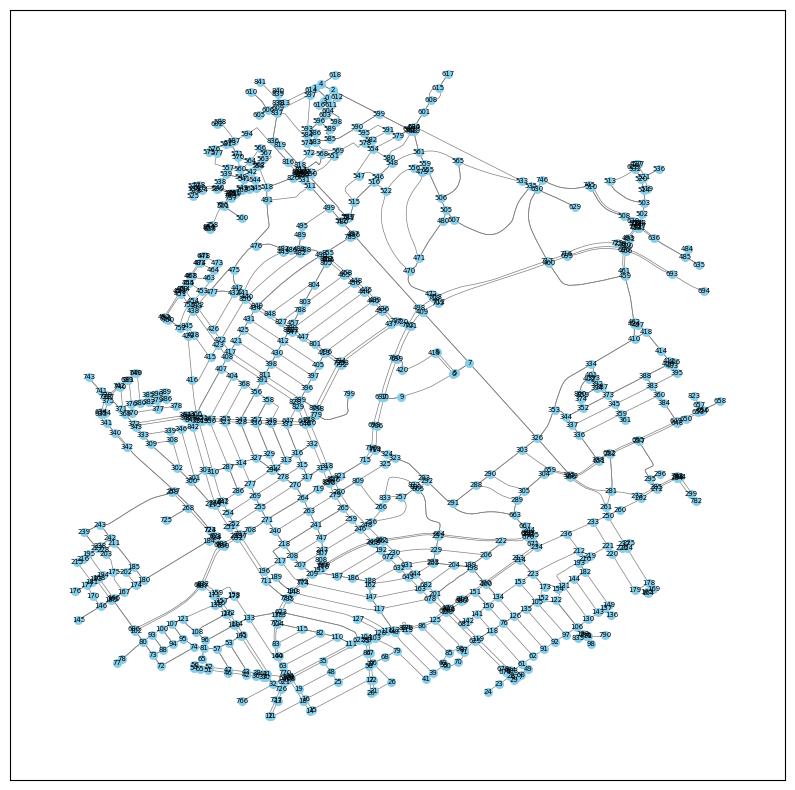

In [30]:
from matplotlib.collections import LineCollection

# Prepare edge geometries
edge_lines = []
for u, v, data in G6.edges(data=True):
    if 'geometry' in data and data['geometry']:  
        edge_lines.append(list(data['geometry'].coords))
    else:
        # Fallback to straight line between nodes
        edge_lines.append([pos[u], pos[v]])

# Create LineCollection for edges
lc = LineCollection(edge_lines, colors='gray', linewidths=0.5)

# Plot the graph
fig, ax = plt.subplots(figsize=(10, 10))
ax.add_collection(lc)

# Draw the nodes
nx.draw_networkx_nodes(G6, pos, ax=ax, node_size=30, node_color='skyblue')

# Optionally add labels
nx.draw_networkx_labels(G6, pos, ax=ax, font_size=5)

# Adjust plot limits and display the figure
ax.autoscale()
ax.margins(0.1)
plt.show()

In [31]:
# Check nodes with no connections (degree 0)
isolated_nodes = [node for node in G6.nodes if G6.degree(node) == 0]
if isolated_nodes:
    print("Nodes with no connections:")
    for node in isolated_nodes:
        print(node)

# Check edges with no valid connections
for u, v, data in G6.edges(data=True):
    if G6.degree(u) == 0 or G6.degree(v) == 0:
        print(f"Edge between {u} and {v} has no valid connections.")


Nodes with no connections:
680


Node 680 has no connections so that node will be dropped

In [32]:
# Remove node 680 from the graph
G6.remove_node(680)

# Drop node 680 from the dataframe
nodes = nodes[nodes['nodeID'] != 680]

Create a dataframe for cars and add car_id, start and end node, travel time and current edge. 

In [33]:
import random

# Create the DataFrame for cars (100 cars)
cars = pd.DataFrame({
    'car_id': range(1, 101),  # 100 cars
    'start_node': random.choices(list(G6.nodes), k=100),
    'end_node': random.choices(list(G6.nodes), k=100),
    'total_travel_time': 0,
    'current_edge': None,  # Initially, cars are not on any edge
    'path_log': [[] for _ in range(100)],  # Initialize empty path_log
    'nodes_visited': [[] for _ in range(100)],  # Initialize empty nodes_visited
    'edges_visited': [[] for _ in range(100)],  # Initialize empty edges_visited
    'total_delay': 0
})
display(cars.head())


,car_id,start_node,end_node,total_travel_time,current_edge,path_log,nodes_visited,edges_visited,total_delay
0,1,392,676,0,None,[],[],[],0
1,2,415,317,0,None,[],[],[],0
2,3,258,196,0,None,[],[],[],0
3,4,698,136,0,None,[],[],[],0
4,5,764,66,0,None,[],[],[],0


Add edge weights for capacity of the roads and delay column

In [34]:
# Add capacity and delay columns to edges
for u, v, data in G6.edges(data=True):
    length = data.get('length', 1)  # Use get() to provide a default value
    lanes = data.get('lanes', 1)
    data['capacity'] = length * lanes * 0.1  # Capacity factor
    data['current_cars'] = 0  # Initially, no cars on the edge
    data['delay'] = 0  # Delay set to 0 initially

In [35]:
# Check the attributes of a few edges
for u, v, data in list(G6.edges(data=True))[:5]:  # Inspect the first 5 edges
    print(f"Edge ({u}, {v}):")
    print(f"  Length: {data.get('length', 'N/A')}")
    print(f"  Lanes: {data.get('lanes', 'N/A')}")
    print(f"  Capacity: {data.get('capacity', 'N/A')}")
    print(f"  Current Cars: {data.get('current_cars', 'N/A')}")
    print(f"  Delay: {data.get('delay', 'N/A')}")
    print()

Edge (0, 1):
  Length: 75.92
  Lanes: 2
  Capacity: 15.184000000000001
  Current Cars: 0
  Delay: 0

Edge (0, 2):
  Length: 46.188
  Lanes: 2
  Capacity: 9.2376
  Current Cars: 0
  Delay: 0

Edge (0, 3):
  Length: 21.749
  Lanes: 2
  Capacity: 4.3498
  Current Cars: 0
  Delay: 0

Edge (1, 0):
  Length: 75.92
  Lanes: 2
  Capacity: 15.184000000000001
  Current Cars: 0
  Delay: 0

Edge (1, 4):
  Length: 32.299
  Lanes: 2
  Capacity: 6.4598
  Current Cars: 0
  Delay: 0



Add delay column to the nodes

In [36]:
# Add delay column to nodes
for node in G6.nodes:
    G6.nodes[node]['current_cars'] = 0  # Count of cars on the node
    G6.nodes[node]['delay'] = 0  # Default delay

# Base scenario

In [37]:
# Add paths to the cars (we'll use the 'length' as a weight for shortest path)
for idx, car in cars.iterrows():
    start_node = car['start_node']
    end_node = car['end_node']
    try:
        # Calculate the shortest path for each car and store it in path_log
        path = nx.shortest_path(G6, start_node, end_node, weight='length')
        cars.at[idx, 'path_log'] = path
        cars.at[idx, 'nodes_visited'] = path  # Store the nodes visited in order
    except nx.NetworkXNoPath:
        print(f"No path found for car {car['car_id']}")

No path found for car 17
No path found for car 31
No path found for car 42
No path found for car 53
No path found for car 99
No path found for car 100


In [38]:
# Function to simulate car movement over timesteps and update delay and travel time
def move_cars_over_time(cars, max_timesteps=100):
    for t in range(max_timesteps):  # Iterate through time steps
        for idx, car in cars.iterrows():
            # Ensure the car has a valid path to move along
            if len(car['path_log']) > 1:  # There should be more than 1 node to move
                current_node = car['path_log'][0]  # Get the current node
                next_node = car['path_log'][1]  # Get the next node in the path
                
                # Calculate delay at the current node (if more than 1 car at the node)
                if G6.nodes[current_node]['current_cars'] > 1:
                    car['total_delay'] += 3  # Add 3 minutes delay for congestion at node
                    
                # Update total travel time as the car moves to the next node
                edge_data = G6.get_edge_data(current_node, next_node)
                edge_length = edge_data.get('length', 1)
                edge_delay = 0
                # Add delay on the edge if too many cars are on it
                if edge_data['current_cars'] > 3:
                    edge_delay = 5  # Add 5 minutes delay on the edge
                car['total_travel_time'] += edge_length + edge_delay  # Update travel time
                
                # Move car to the next node in its path
                car['path_log'] = car['path_log'][1:]  # Remove the current node from the path
                G6.nodes[current_node]['current_cars'] -= 1  # Decrease the current car count at the node
                G6.nodes[next_node]['current_cars'] += 1  # Increase the current car count at the next node
                G6.edges[current_node, next_node]['current_cars'] += 1  # Update car count on the edge
                
                # Add the node to nodes_visited (ensure uniqueness)
                if next_node not in car['nodes_visited']:
                    car['nodes_visited'].append(next_node)

                # Add the edge to edges_visited (ensure uniqueness)
                edge = tuple(sorted([current_node, next_node]))  # Use sorted to avoid direction differences
                if edge not in car['edges_visited']:
                    car['edges_visited'].append(edge)

            else:
                # If the car has finished its path, do not modify path_log or travel times anymore
                if len(car['path_log']) == 1:  # Car reached destination
                    # Do not modify path_log anymore
                    continue

            # Ensure that changes are reflected in the dataframe
            cars.at[idx, 'total_travel_time'] = car['total_travel_time']
            cars.at[idx, 'total_delay'] = car['total_delay']
            cars.at[idx, 'path_log'] = car['path_log']

        # Debugging: Print progress every 10 timesteps
        if t % 10 == 0:
            print(f"Step {t}:")
            print(cars[['car_id', 'total_travel_time', 'total_delay', 'path_log']].head())
    
    return cars

In [39]:
# Finalizing results: Ensure start_node is added to the start and end_node to the end of nodes_visited
def finalize_results(cars):
    for idx, car in cars.iterrows():
        # Ensure start_node is at the beginning and end_node is at the end of nodes_visited
        if car['start_node'] not in car['nodes_visited']:
            car['nodes_visited'].insert(0, car['start_node'])  # Add start_node at the beginning
        if car['end_node'] not in car['nodes_visited']:
            car['nodes_visited'].append(car['end_node'])  # Add end_node at the end

    return cars

In [40]:
# Final results DataFrame: Create a DataFrame with unique nodes and edges visited
def create_final_dataframe(cars):
    final_results = pd.DataFrame({
        'car_id': cars['car_id'],
        'start_node': cars['start_node'],
        'end_node': cars['end_node'],
        'total_travel_time': cars['total_travel_time'],
        'total_delay': cars['total_delay'],
        'nodes_visited': [list(set(nodes)) for nodes in cars['nodes_visited']],  # Remove duplicates
        'edges_visited': [list(set(edges)) for edges in cars['edges_visited']]  # Remove duplicates
    })
    
    # Sort the columns (optional for easier inspection)
    final_results = final_results[['car_id', 'start_node', 'end_node', 'total_travel_time', 'total_delay', 'nodes_visited', 'edges_visited']]
    
    return final_results


In [41]:
# Run the simulation
cars = move_cars_over_time(cars, max_timesteps=100)

# Finalize the results (add start_node and end_node)
cars = finalize_results(cars)

# Create the final results DataFrame
final_results = create_final_dataframe(cars)

# Show the final results
display(final_results.head())

Step 0:
   car_id  total_travel_time  total_delay  \
0       1             19.319            0   
1       2            161.326            0   
2       3            105.183            0   
3       4            119.147            0   
4       5             31.786            0   

                                            path_log  
0  [394, 859, 374, 352, 344, 337, 336, 338, 335, ...  
1  [416, 429, 845, 438, 423, 408, 391, 828, 829, ...  
2  [268, 724, 723, 703, 704, 689, 690, 692, 711, ...  
3  [710, 714, 324, 323, 293, 292, 291, 663, 667, ...  
4  [545, 518, 491, 476, 475, 442, 432, 850, 434, ...  
Step 10:
   car_id  total_travel_time  total_delay  \
0       1            800.057            0   
1       2           1331.941            3   
2       3            771.105           21   
3       4           1026.693            6   
4       5            954.365            3   

                                            path_log  
0  [304, 305, 289, 663, 667, 660, 666, 670, 671, ...  
1

,car_id,start_node,end_node,total_travel_time,total_delay,nodes_visited,edges_visited
0,1,392,676,1972.707,3,"[392, 394, 659, 660, 663, 666, 667, 670, 671, ...","[(344, 352), (200, 213), (289, 663), (394, 859..."
1,2,415,317,1622.951,3,"[416, 423, 391, 647, 317, 331, 845, 429, 438, ...","[(423, 438), (415, 416), (331, 647), (315, 316..."
2,3,258,196,771.105,21,"[704, 258, 196, 711, 268, 689, 690, 723, 724, ...","[(692, 711), (689, 704), (703, 704), (690, 692..."
3,4,698,136,1782.905,6,"[136, 137, 660, 149, 663, 666, 667, 670, 671, ...","[(136, 137), (698, 710), (292, 293), (212, 236..."
4,5,764,66,3299.561,12,"[128, 259, 645, 518, 391, 646, 265, 398, 147, ...","[(319, 332), (475, 476), (398, 811), (830, 856..."


In [43]:
# Save the final results to an Excel file
final_results.to_excel('simulation_results.xlsx', index=False)

print("Simulation results saved to 'simulation_results.xlsx'")


Simulation results saved to 'simulation_results.xlsx'


In [44]:
# Check if the graph is strongly connected
if not nx.is_strongly_connected(G6):
    print("Warning: The graph is not strongly connected.")
    components = list(nx.strongly_connected_components(G6))
    print(f"The graph has {len(components)} strongly connected components.")
    for idx, component in enumerate(components):
        print(f"Component {idx + 1}: {component}")

The graph has 32 strongly connected components.
Component 1: {694}
Component 2: {693}
Component 3: {164, 165}
Component 4: {169}
Component 5: {179}
Component 6: {178}
Component 7: {766}
Component 8: {385, 389, 390}
Component 9: {386}
Component 10: {379}
Component 11: {382}
Component 12: {380}
Component 13: {378}
Component 14: {377}
Component 15: {790}
Component 16: {98, 99}
Component 17: {771}
Component 18: {835}
Component 19: {123}
Component 20: {24}
Component 21: {23}
Component 22: {566}
Component 23: {567}
Component 24: {563}
Component 25: {853}
Component 26: {852}
Component 27: {854}
Component 28: {758}
Component 29: {841}
Component 30: {602, 588}
Component 31: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,

Components 1 to 30 and 32 are possibly islands, so we need to take a closer look at them to make sure cars can actually leave or if they get stuck 

In [45]:
# Get components 1 to 30 (index 0 to 29) and component 32 (index 31)
selected_components = components[:30] + [components[31]]

# Print out the selected components
for idx, component in enumerate(selected_components, start=1):
    print(f"Component {idx}: {component}")

Component 1: {694}
Component 2: {693}
Component 3: {164, 165}
Component 4: {169}
Component 5: {179}
Component 6: {178}
Component 7: {766}
Component 8: {385, 389, 390}
Component 9: {386}
Component 10: {379}
Component 11: {382}
Component 12: {380}
Component 13: {378}
Component 14: {377}
Component 15: {790}
Component 16: {98, 99}
Component 17: {771}
Component 18: {835}
Component 19: {123}
Component 20: {24}
Component 21: {23}
Component 22: {566}
Component 23: {567}
Component 24: {563}
Component 25: {853}
Component 26: {852}
Component 27: {854}
Component 28: {758}
Component 29: {841}
Component 30: {602, 588}
Component 31: {791}


In [46]:
# Check which cars are in isolated components (1-30 and 32)
for idx, car in cars.iterrows():
    start_node = car['start_node']
    end_node = car['end_node']
    
    # Check if start or end node belongs to any selected component
    in_isolated_component = any(start_node in component or end_node in component for component in selected_components)
    if in_isolated_component:
        print(f"Car {car['car_id']} is in an isolated component: Start {start_node}, End {end_node}")


Car 7 is in an isolated component: Start 353, End 169
Car 17 is in an isolated component: Start 98, End 473
Car 31 is in an isolated component: Start 165, End 860
Car 42 is in an isolated component: Start 588, End 359
Car 53 is in an isolated component: Start 563, End 265
Car 63 is in an isolated component: Start 742, End 382
Car 72 is in an isolated component: Start 629, End 841
Car 73 is in an isolated component: Start 304, End 693
Car 96 is in an isolated component: Start 725, End 24
Car 99 is in an isolated component: Start 386, End 107
Car 100 is in an isolated component: Start 377, End 134


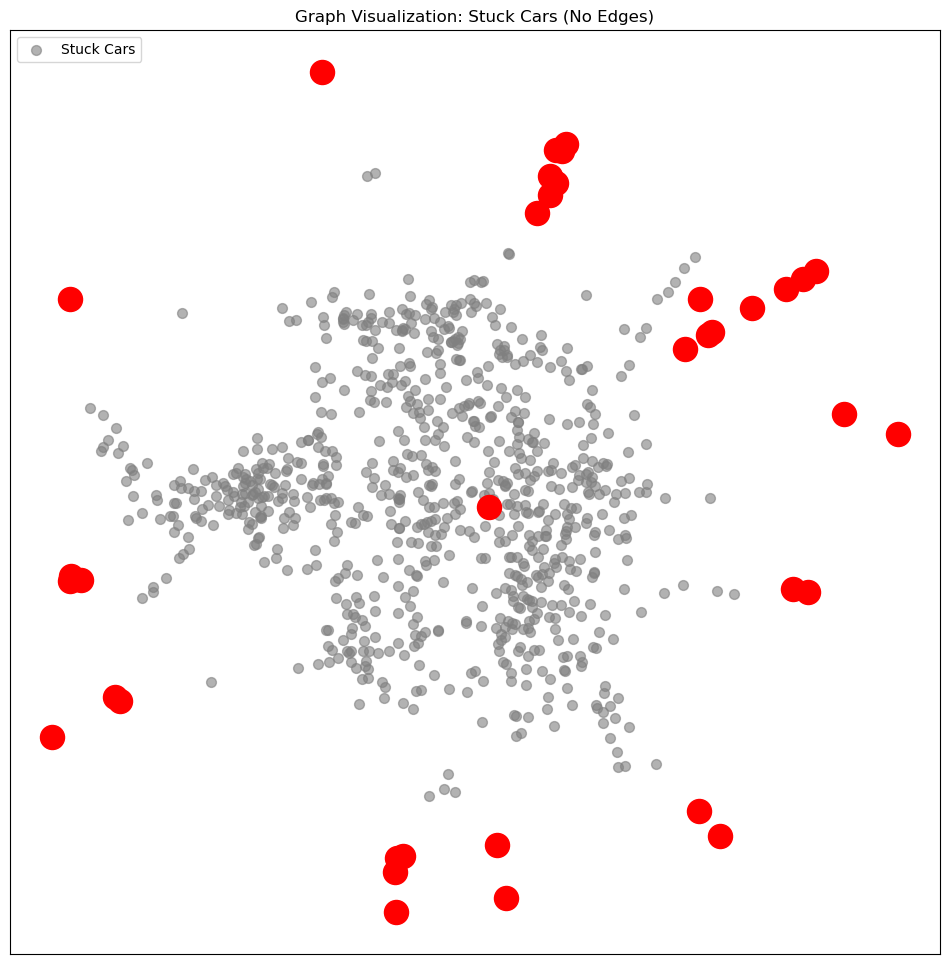

In [47]:
stuck_cars = [
    {'car_id': 17, 'start_node': 766, 'end_node': 576},
    {'car_id': 29, 'start_node': 38, 'end_node': 169},
    {'car_id': 94, 'start_node': 378, 'end_node': 123},
]

# Plot the graph
plt.figure(figsize=(12, 12))

# Position nodes using a layout (e.g., spring layout)
pos = nx.spring_layout(G6, seed=42)

# Draw only the nodes (no edges)
nx.draw_networkx_nodes(G6, pos, node_size=50, node_color='gray', alpha=0.6)

# Highlight the isolated components (in red)
isolated_nodes = [node for component in selected_components for node in component]
nx.draw_networkx_nodes(G6, pos, nodelist=isolated_nodes, node_size=300, node_color='red', label="Isolated Components")

# Add legend (optional)
plt.legend(["Stuck Cars"], loc="upper left")

# Display the plot
plt.title("Graph Visualization: Stuck Cars (No Edges)")
plt.show()

# Closed lanes

In [48]:
# Step 1: Create a copy of the original cars dataframe
cars_with_path = cars.copy()

# Step 2: Calculate the shortest path for each car, considering closed edges
for idx, car in cars_with_path.iterrows():
    start_node = car['start_node']
    end_node = car['end_node']
    
    # Remove edges marked as closed from the graph
    closed_edges = [(u, v) for u, v, data in G6.edges(data=True) if data.get('Closed', False)]
    
    # Remove the closed edges from the graph temporarily
    G6.remove_edges_from(closed_edges)
    
    try:
        # Calculate the shortest path with the remaining open edges
        path = nx.shortest_path(G6, start_node, end_node, weight='length')
        # Store the new path in path_log
        cars_with_path.at[idx, 'path_log'] = path  # Save the updated path_log in the dataframe
    except nx.NetworkXNoPath:
        print(f"No path found for car {car['car_id']}")
    
    # Restore the closed edges to the graph
    G6.add_edges_from(closed_edges)


No path found for car 17
No path found for car 31
No path found for car 42
No path found for car 53
No path found for car 99
No path found for car 100


In [49]:
# Initialize 'current_cars' for nodes and edges if not done already
for u, v, data in G6.edges(data=True):
    if 'current_cars' not in data:
        data['current_cars'] = 0  # Set the initial number of cars on the edge to 0


In [50]:
# Function to simulate car movement over timesteps and update delay and travel time
def move_cars_over_time(cars, max_timesteps=100):
    for t in range(max_timesteps):  # Iterate through time steps
        for idx, car in cars.iterrows():
            # Ensure the car has a valid path to move along
            if len(car['path_log']) > 1:  # There should be more than 1 node to move
                current_node = car['path_log'][0]  # Get the current node
                next_node = car['path_log'][1]  # Get the next node in the path
                
                # Calculate delay at the current node (if more than 1 car at the node)
                if G6.nodes[current_node]['current_cars'] > 1:
                    car['total_delay'] += 3  # Add 3 minutes delay for congestion at node
                    
                # Update total travel time as the car moves to the next node
                edge_data = G6.get_edge_data(current_node, next_node)
                edge_length = edge_data.get('length', 1)
                edge_delay = 0
                # Add delay on the edge if too many cars are on it
                if edge_data['current_cars'] > 3:
                    edge_delay = 5  # Add 5 minutes delay on the edge
                car['total_travel_time'] += edge_length + edge_delay  # Update travel time
                
                # Move car to the next node in its path
                car['path_log'] = car['path_log'][1:]  # Remove the current node from the path
                G6.nodes[current_node]['current_cars'] -= 1  # Decrease the current car count at the node
                G6.nodes[next_node]['current_cars'] += 1  # Increase the current car count at the next node
                G6.edges[current_node, next_node]['current_cars'] += 1  # Update car count on the edge
                
                # Add the node to nodes_visited (ensure uniqueness)
                if next_node not in car['nodes_visited']:
                    car['nodes_visited'].append(next_node)

                # Add the edge to edges_visited (ensure uniqueness)
                edge = tuple(sorted([current_node, next_node]))  # Use sorted to avoid direction differences
                if edge not in car['edges_visited']:
                    car['edges_visited'].append(edge)

            else:
                # If the car has finished its path, do not modify path_log or travel times anymore
                if len(car['path_log']) == 1:  # Car reached destination
                    # Do not modify path_log anymore
                    continue

            # Ensure that changes are reflected in the dataframe
            cars.at[idx, 'total_travel_time'] = car['total_travel_time']
            cars.at[idx, 'total_delay'] = car['total_delay']
            cars.at[idx, 'path_log'] = car['path_log']

        # Debugging: Print progress every 10 timesteps
        if t % 10 == 0:
            print(f"Step {t}:")
            print(cars[['car_id', 'total_travel_time', 'total_delay', 'path_log']].head())
    
    return cars


In [51]:
# Finalize the results (add start_node and end_node)
def finalize_results(cars):
    for idx, car in cars.iterrows():
        # Ensure start_node is at the beginning and end_node is at the end of nodes_visited
        if car['start_node'] not in car['nodes_visited']:
            car['nodes_visited'].insert(0, car['start_node'])  # Add start_node at the beginning
        if car['end_node'] not in car['nodes_visited']:
            car['nodes_visited'].append(car['end_node'])  # Add end_node at the end
    return cars


In [52]:
# Final results DataFrame: Create a DataFrame with unique nodes and edges visited
def create_final_dataframe(cars):
    final_results = pd.DataFrame({
        'car_id': cars['car_id'],
        'start_node': cars['start_node'],
        'end_node': cars['end_node'],
        'total_travel_time': cars['total_travel_time'],
        'total_delay': cars['total_delay'],
        'nodes_visited': [list(set(nodes)) for nodes in cars['nodes_visited']],  # Remove duplicates
        'edges_visited': [list(set(edges)) for edges in cars['edges_visited']]  # Remove duplicates
    })
    
    # Sort the columns (optional for easier inspection)
    final_results = final_results[['car_id', 'start_node', 'end_node', 'total_travel_time', 'total_delay', 'nodes_visited', 'edges_visited']]
    
    return final_results


In [53]:
# Run the simulation
cars_with_path = move_cars_over_time(cars_with_path, max_timesteps=100)

# Finalize the results (add start_node and end_node)
cars_with_path = finalize_results(cars_with_path)

# Create the final results DataFrame
final_results2 = create_final_dataframe(cars_with_path)

# Show the final results
display(final_results2.head())


Step 0:
   car_id  total_travel_time  total_delay  \
0       1           1992.026            3   
1       2           1784.277            3   
2       3            876.288           21   
3       4           1783.905            6   
4       5           3331.347           12   

                                            path_log  
0  [394, 859, 374, 352, 344, 337, 336, 338, 335, ...  
1  [416, 429, 845, 438, 423, 408, 391, 828, 829, ...  
2  [268, 724, 723, 703, 704, 689, 690, 692, 711, ...  
3  [710, 714, 324, 323, 293, 292, 291, 663, 667, ...  
4  [545, 518, 826, 825, 813, 531, 511, 499, 512, ...  
Step 10:
   car_id  total_travel_time  total_delay  \
0       1           2797.764            3   
1       2           2974.892            3   
2       3           1562.210           42   
3       4           2233.023           18   
4       5           3966.806           15   

                                            path_log  
0  [304, 305, 289, 663, 667, 660, 666, 670, 671, ...  
1

,car_id,start_node,end_node,total_travel_time,total_delay,nodes_visited,edges_visited
0,1,392,676,4020.414,6,"[392, 394, 659, 660, 663, 666, 667, 670, 671, ...","[(344, 352), (200, 213), (289, 663), (394, 859..."
1,2,415,317,3265.902,3,"[416, 423, 391, 647, 317, 331, 845, 429, 438, ...","[(423, 438), (415, 416), (331, 647), (315, 316..."
2,3,258,196,1562.210,42,"[704, 258, 196, 711, 268, 689, 690, 723, 724, ...","[(692, 711), (689, 704), (703, 704), (690, 692..."
3,4,698,136,3004.235,21,"[136, 137, 660, 149, 663, 666, 667, 670, 671, ...","[(136, 137), (698, 710), (292, 293), (212, 236..."
4,5,764,66,5945.469,30,"[128, 512, 259, 645, 518, 391, 646, 265, 780, ...","[(319, 332), (475, 476), (398, 811), (830, 856..."


In [54]:
# Save the final results to an Excel file
final_results2.to_excel('simulation_results_closed_roads.xlsx', index=False)

print("Simulation results saved to 'simulation_results_closed_roads.xlsx'")


Simulation results saved to 'simulation_results_closed_roads.xlsx'
